In [1]:
import numpy as np
import pandas as pd
import time
import os
from datetime import datetime
from IPython.display import clear_output
from IPython import display
import matplotlib.pyplot as plt
#from numba import njit

In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import optuna

using gpu 0


In [3]:
def coord_to_ind(X,Y,Z,lot_size):
    return np.ravel_multi_index((X,Y,Z), lot_size)

#Zet de index in array om naar X,Y,Z coördinaten
def ind_to_coord(ind, lot_size):
    return np.unravel_index(ind,lot_size)

#Geeft van een gegeven containerindex in de lotindeling de twee wegen om deze container te bereiken
def cont_routes(lot_indeling, lot_size, ind): #lot_indeling: array, lot_size: [x,y,z], ind: int
    X = lot_size[0]
    Y = lot_size[1]
    Z = lot_size[2]
    lot_index = np.arange(np.prod(lot_size)).reshape(lot_size) #lotindeling maar dan de indexes
    indc = ind_to_coord(ind, lot_size) #vind coördinaten van ingevoerde index
    
    #voeg de containerstack waar de betreffende container in zit toe aan de dictionary als start van de route
    stackvalue = lot_indeling[indc[0]][indc[1]]
    stackkey = lot_index[indc[0]][indc[1]]
    stackdict = dict(zip(stackkey,stackvalue))
    
    #route 1 berekenen
    routestart = {k: v for k, v in stackdict.items() if k >= ind}
    route1 = routestart
    i = 0
    while (lot_index[indc[0]][indc[1]-i][0] % (Y*Z)) > 0:
        for z in range(Z):
            route1[lot_index[indc[0]][indc[1]-(i+1)][z]] = lot_indeling[indc[0]][indc[1]-(i+1)][z]
        i += 1
    
    #route 2 berekenen
    routestart = {k: v for k, v in stackdict.items() if k >= ind}
    route2 = routestart
    i = 0
    while (lot_index[indc[0]][indc[1]+i][Z-1] % (Y*Z)) < (Y*Z-1):
        for z in range(Z):
            route2[lot_index[indc[0]][indc[1]+(i+1)][z]] = lot_indeling[indc[0]][indc[1]+(i+1)][z]
        i += 1
    
    return route1, route2 #route1: dictionary, route2: dictionary


#Geeft de score van een indeling terug
def score_eindveld(lot_indeling):
    X,Y,Z = lot_indeling.shape
    
    lot_index = np.arange(np.prod(lot_indeling.shape)).reshape(lot_indeling.shape)
    
    #maak een lijst van alle verschillende prio indexen in de indeling
    #'0' geeft een lege plek aan, dus die telt niet mee
    #de hoogste waarde (laagste prio) nemen we niet mee
    if np.unique(lot_indeling)[0] == '0':
        lot_unique = np.unique(lot_indeling)[1:-1]
    else:
        lot_unique = np.unique(lot_indeling)[:-1]

    #beloon 0 rijen alleen bij een X >= 1, Y >= 3, Z >= 1
    inbox = 0
    
    for p in lot_unique:
    
        for i in range(len(np.where(lot_indeling == p)[0])):
            obstaclesdict = {}
            x,y,z = np.array(np.where(lot_indeling == p))[:,i]
            
            #x = np.where(lot_indeling == p)[0][i]
            #y = np.where(lot_indeling == p)[1][i]
            #z = np.where(lot_indeling == p)[2][i]
            routes = cont_routes(lot_indeling, lot_indeling.shape, lot_index[x][y][z])
            routelen1 = len({k: v for k,v in routes[0].items() if int(v) > int(p)})
            routelen2 = len({k: v for k,v in routes[1].items() if int(v) > int(p)})

            #kies eerste route als die korter is dan tweede
            if routelen1 < routelen2:
                shortroute = routes[0]
            #kies tweede route als die korter is dan eerste
            elif routelen1 > routelen2:
                shortroute = routes[1]
            #als beide routes even lang zijn, kijk dan hoeveel containers op de route dezelfde prio klasse hebben
            else:
                sameclassroute1 = sum(1 for v in routes[0].values() if v <= list(routes[0].values())[0])
                sameclassroute2 = sum(1 for v in routes[1].values() if v <= list(routes[1].values())[0])
                #kies eerste route als aantal dezelfe prio klasse containers gelijk aan of meer is dan tweede
                if sameclassroute1 >= sameclassroute2:
                    shortroute = routes[0]
                #kies tweede route als aantal dezelfe prio klasse containers meer is dan eerste
                else:
                    shortroute = routes[1]
            
            #sla alle containers op die op de route in de weg zitten (de containers met een hogere prioklasse)
            for c in shortroute:
                if int(shortroute[c]) > int(p):
                    obstaclesdict[c] = shortroute[c]
            
            #score omlaag als containers in de weg zitten
            if len(obstaclesdict) > 0:
                inbox += 1

    
    return inbox #score: integer

In [4]:
#Input: een keuze tussen bij 4 keuzes (bij 4x?x?)
#Output: Nieuwe environment


class Environment:
    def __init__(self, size, posreward = 2, negreward = -2, maxPriority = 4):
        self.size = size
        self.environment = np.array([[[0] * self.size[2]] * self.size[1]] * self.size[0])
        self.posreward = posreward
        self.negreward = negreward
        self.action_space = size[0]
        self.input_space = size[0]*(maxPriority+1)+1
        self.priorityMax = maxPriority
        
    def resetField(self):
        self.environment = np.array([[[0] * self.size[2]] * self.size[1]] * self.size[0])
        
    def resetEnvironment(self):
        self.resetField()
        self.score = 0
        self.done = False
    
    def GenerateEnvironment(self):
        return np.array([[[0] * self.size[2]] * self.size[1]] * self.size[0])
        temp = np.array([[[0] * self.size[2]] * self.size[1]] * self.size[0])
        maxcont = self.size[0] * self.size[2]
        for i in range(self.size[1]):
            for o in range(np.random.randint(maxcont*0.65,maxcont)):
                actionPos = self.checkValidPositionInRow(temp,i)
                temp[actionPos] = 1
        return temp
    
    
    #TODO: Voeg een boolean output toe van welke rows al vol zitten en welke niet.
    def genObs(self, env, containerType = 1, flattened = True, normalized = False):
        #Count amount of open containers per row.
        outputlist = np.zeros((self.priorityMax+1,self.size[0]),dtype=np.float32)

        for i in range(self.priorityMax):
            outputlist[i] = (env == i).sum(axis=2).sum(axis=1)
        
        outputlist[-1] = (env != 0).sum(axis=2).sum(axis=1) == np.prod(env.shape[1:3])
        
        if normalized:
            outputlist[:-1] /= np.prod(env.shape[1:3])
        
        
        if flattened:
            return np.concatenate((outputlist.flatten(), np.array([containerType],dtype=np.float32)))
        else:
            return [outputlist,containerType]
    
    def step(self, env, action, priority = 1):
        #actionspace = y
        
        
        #Save Old State
        newState = env.copy()
        actionPos = self.checkValidPositionInRow(env, action)
        
        done = False
        
        #Make move
        if self.placeContainer(actionPos, newState):
            newState[actionPos] = priority
            reward = self.getRewardList(env, priority)[action]
        else:
            reward = np.prod(env.shape[1:3]) * -2
            done = True
            self.done = True

        #End game if field is all filled.
        if np.all(newState != 0):
            done = True
            self.done = True
        return newState, reward, done
    
    def placeContainer(self, pos, env):
        if self.isLegal(pos, env):
            return True
        else:
            return False
        
    def isLegal(self, pos, env):
        IO = self.isOccupied(pos, env)
        IF = self.isFloating(pos, env)
        IIE = self.posIsInEnv(pos, env)
        NAS = self.hasNorthAndSouth(pos, env)
        return not IO and not IF and IIE and not NAS
    
    def isOccupied(self, pos, env):
        if self.posIsInEnv(pos, env):
            return env[pos] != 0
        else:
            return False
    
    def hasNorthAndSouth(self, pos, env):
        NC = self.isOccupied((pos[0],pos[1]-1,0), env)
        SC = self.isOccupied((pos[0],pos[1]+1,0), env)
        return NC and SC
    
    def posIsInEnv(self, pos, env):
        x = 0 <= pos[0] < env.shape[0]
        y = 0 <= pos[1] < env.shape[1]
        z = 0 <= pos[2] < env.shape[2]  
        return x and y and z
    
    def isFloating(self, pos, env):
        return np.any(env[pos[0],pos[1],:pos[2]] == 0)
    
    def checkValidPositionInRow(self, env, row):
        positions = np.dstack(np.where(env[row,:,:] == 0))
        if positions.size != 0:
            result = positions[positions[:,:,0] == np.max(positions[:,:,0])][0]
            
        else:
            result = (0,0)
        return row, result[0], result[1]
    
    def getRewardList(self,env,containerPriority):
        obs = self.genObs(env,containerPriority,flattened=False)
        #
        emptyRows = obs[0][0] == np.prod(env.shape[1:3])
        amtRows = obs[0][1:-1].sum(axis=0)
        prioRows = obs[0][1:-1]
        fullRows = obs[0][-1]
        containerRow = prioRows[containerPriority-1]
        ratioRow = containerRow/amtRows
        ratioRow[ratioRow == np.inf] = 0
        ratioRow[np.isnan(ratioRow)] = 0
        #print(fullRows)
        result = ratioRow+emptyRows/2
        #result[fullRows] = 0
        result *= fullRows*-1 + 1
        #print(result)
        
        #result = obs[0][1:-1].sum(axis=0) * (obs[0][-1]+1) - np.prod(env.shape[1:3]) * (obs[0][-1]*-1) + emptyRows
        
        return result

# Model

Agent(
    -Environment
    -CNN
    -Trainer)
    
    
    
# Pseudo pseudocode
<code>N = 10</code>

<code>While True:</code><br>
<code>    //Gaming moment (play 10 games)</code><br>
<code>    for i in range(10):</code><br>
<code>        pred = agent.pred()</code><br>
<code>        agent.rememberMoves()</code><br>
<code>    //Learning moment (train on previous games if possible)</code><br>
<code>    agent.trainNN()</code><br>

TODO: INCLUDE SCORING



# Convolutional Neural Network

In [5]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, n_actions, fc1_dims=64, fc2_dims=64):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.sigmoid = nn.Sigmoid()
        self.to(self.device)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        
        return actions

In [6]:
class Agent():
    def __init__(self, gamma, lr, batch_size, max_mem_size=100000, size = (3,3,2),epsilon = 0.99, eps_end=0.01, eps_dec=5e-3):
        
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        
        
        self.lr = lr
        self.gamma = gamma
        
        #Create Environment
        self.env = Environment(size)
        
        #self.action_space = self.env.action_space
        self.action_space = [i for i in range(self.env.action_space)]
        
        #Create Convolutional Neural Network
        self.Q_eval = DeepQNetwork(lr = lr, input_dims = self.env.input_space, n_actions = self.env.action_space)
        
        #Memory variables
        self.mem_size = max_mem_size
        self.mem_cntr = 0
        self.batch_size = batch_size
        
        #Memory array variables
        self.state_memory = np.zeros((self.mem_size, self.env.input_space), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, self.env.input_space), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)
        
    def chooseAction(self, observation):
        if np.random.random() > self.epsilon:
            #Turn observation into tensor
            state = T.tensor([observation]).to(self.Q_eval.device)
            #Get action from neural network
            actions = self.Q_eval.forward(state)

            #Get maximum value and return index
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action
        
    def rememberMoves(self, state, action, reward, state_, done):
        #Makes counter loop over if max has been reached.
        index = self.mem_cntr % self.mem_size
        
        #Save specific variables to arrays
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        
        #Increment memory counter
        self.mem_cntr += 1

In [7]:
def getRowScore(row, height, priority):
    side = row[1:] <= priority
    above = row[0][height:] <= priority
    total = side.sum() + above.sum()
    totalcontainers = side.size+above.size
    return total/totalcontainers
    
def getContainerMovementScore(row,pos,prio):
    right=row[pos[0]:,:]
    left=np.flip(row[:pos[0]+1,:],axis=0)
    return min(getRowScore(left,pos[1],prio),getRowScore(right,pos[1],prio))

def rowScore(env):
    totalScore = 0
    #Per row
    for row in env:
        it = np.nditer(row, flags=['multi_index'])
        for container in it:
            totalScore += getContainerMovementScore(row,it.multi_index,container)

    
    return totalScore

In [14]:
np.seterr(invalid='ignore')


a = Agent(0.95, 0.01, 256, size=(4, 4, 5),epsilon=0,eps_end=0)
a.Q_eval.load_state_dict(T.load("StateDicts/01-18-2023-16-37-54(4x4x5).statedict"))
a.Q_eval.eval()

RewardHistory = []
RewardHistoryHistory = []

done = False

seeds = [29,49,68,239,59,214,29,213,489,2148,582318,38258,231488]
n_games = len(seeds)

lastObservation = 0
startTime = datetime.now()

compareScores = []
compareScoresInbox = []

#Create Folder for saves
foldername = "Observations/"+startTime.strftime("%m-%d-%Y-%H-%M-%S")
os.mkdir(foldername)

scoresinbox = []
scores = []
#Neural Network Trial
for o in range(n_games):
    

    #Resetting variables
    a.env.resetEnvironment()
    done = False
    episodescore = []
    boardObservations = []
    
    #Setting Seed
    np.random.seed(seeds[o])
    
    #Create empty environment
    env = a.env.GenerateEnvironment()
    
    #Generate random container lot
    priorityList = np.random.randint(1,a.env.priorityMax,size=(np.prod(env.size)))

    
    
    #Start game
    while not a.env.done:
        #View state
        obs = a.env.genObs(env,priorityList[-1],normalized=True)
        #Choose Action
        action = a.chooseAction(obs)
        #Check Action
        newenv, reward, done = a.env.step(env,action,priority=priorityList[-1])
        
        #Pop last container
        priorityList = priorityList[:-1]

        #Update board
        env = newenv
        
        #Append board to boardobservations
        boardObservations.append(env)

        #Append score to episodeScore
        episodescore.append(reward)

    print("Episode %i/%i score %.2f"%(o+1,n_games,np.array(episodescore).sum()),flush=True)
    
    
    scores.append(rowScore(env))
    scoresinbox.append(score_eindveld(env))
    #scores.append(np.array(episodescore).sum())

compareScoresInbox.append(scoresinbox)
compareScores.append(scores)
scoresinbox = []
scores = []
#Random Trial
for o in range(n_games):
    done = False
    episodescore = []
    boardObservations = []
    
    #Setting Seed
    np.random.seed(seeds[o])
    
    #Create empty environment
    env = a.env.GenerateEnvironment()
    
    #Generate random container lot
    priorityList = np.random.randint(1,a.env.priorityMax,size=(np.prod(env.size)))

    #Start game
    while not done:
        #View state
        obs = a.env.genObs(env,priorityList[-1],normalized=False,flattened=False)
        
        #Calculate action space
        choicespace = np.arange(a.env.size[0])[obs[0][0] != 0]
        
        #Choose Action
        action = np.random.choice(np.arange(a.env.size[0])[obs[0][0] != 0])
        #Check Action
        newenv, reward, done = a.env.step(env,action,priority=priorityList[-1])
        
        #Pop last container
        priorityList = priorityList[:-1]

        #Update board
        env = newenv
        
        #Append board to boardobservations
        boardObservations.append(env)

        #Append score to episodeScore
        episodescore.append(reward)
        
    print("Episode %i/%i score %.2f"%(o+1,n_games,np.array(episodescore).sum()),flush=True)
    scores.append(rowScore(env))
    scoresinbox.append(score_eindveld(env))
compareScoresInbox.append(scoresinbox)
compareScores.append(scores)
clear_output()
pd.DataFrame(compareScores)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,66.568691,69.125249,69.432397,69.785941,70.856320,74.633826,66.568691,67.334697,73.297707,68.766536,69.170959,72.105086,70.255294
1,54.087772,51.174974,51.183210,51.958368,52.710318,53.826497,54.087772,56.225828,52.703100,53.656549,52.365640,54.695910,54.465933


In [9]:
endTime = datetime.now()

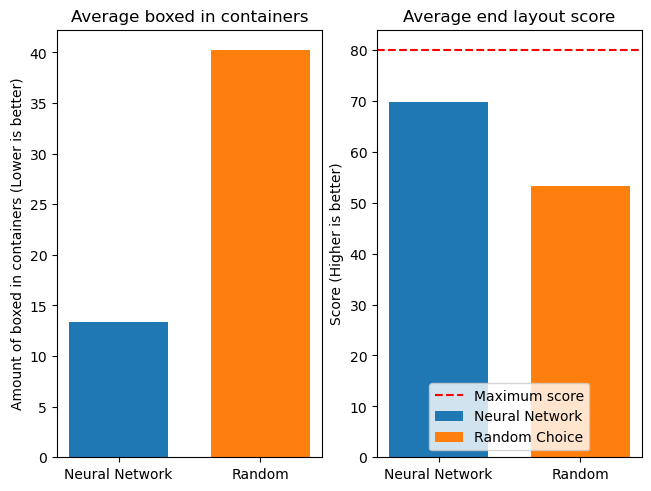

In [90]:

width = 0.7
labels = ["Neural Network","Random"]
x = np.arange(len(labels))
fig, (ax1,ax2) = plt.subplots(ncols=2,layout="constrained")

ax1.set_title("Average boxed in containers")
ax1.set_ylabel("Amount of boxed in containers (Lower is better)")
ax1.bar(0,np.array(compareScoresInbox[0]).mean(),width,label = "Neural Network")
ax1.bar(1,np.array(compareScoresInbox[1]).mean(),width,label = "Random Choice")
ax1.set_xticks(x, labels)

ax2.set_title("Average end layout score")
ax2.set_ylabel("Score (Higher is better)")
ax2.axhline(y=np.prod(env.size),c="red",linestyle="--", label="Maximum score")
ax2.bar(0,np.array(compareScores[0]).mean(),width,label = "Neural Network")
ax2.bar(1,np.array(compareScores[1]).mean(),width,label = "Random Choice")
ax2.set_xticks(x, labels)
ax2.legend(loc="lower center")

plt.show()